In [1]:
from IPython.display import display, clear_output
import numpy as np
import pyopencl as cl
from PIL import Image
import timeit

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable

In [3]:
from simulation import Scene

%load_ext autoreload
%autoreload 2

In [4]:
ctx = cl.create_some_context()

In [5]:
torch.cuda.is_available()

True

In [43]:
cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.down = nn.ModuleList([
            nn.ModuleList([
                nn.Conv2d(3, 16, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2, return_indices=True),
            ]),
        ])

        self.up = nn.ModuleList([
            nn.ModuleList([
                nn.MaxUnpool2d(2, stride=2),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(16, 3, kernel_size=5, padding=2),
            ]),
        ])
    
    def forward(self, x):
        indices = []
        for d in self.down:
            for l in d:
                x = l(x)
            x, idx = x
            indices.append(idx)
        
        for u, idx in zip(self.up, reversed(indices)):
            x = x, idx
            for l in u:
                x = l(*x)
                x = x,
            x, = x
        
        return x

In [60]:
model = Net().cuda()

In [8]:
def random_draw(scene, n):
    for i in range(n):
        x = np.random.uniform(0, scene.size[0])
        y = np.random.uniform(0, scene.size[1])
        l = min(scene.size[0], scene.size[1])
        r = np.random.uniform(0.01*l, 0.25*l)
        v = 0.25*l;
        vx = np.random.uniform(-v, v)
        vy = np.random.uniform(-v, v)
        #c = np.random.randint(1, 8)
        #col = ((c>>0)&1,(c>>1)&1,(c>>2)&1)
        col = (0,1,0)
        scene.draw("circle", col, (vx, vy), (x, y), r)

In [13]:
scene = Scene(
    ctx,
    (64, 64),
    params={
        "time_step": 1/24,
        "grid_size": 0.001,
        "pressure_steps": 64,
        "viscosity": 1e-4,
})
random_draw(scene, 10)
seq = []
for i in range(10*24):
    scene.step()
    scene.buffers["color"].load(scene.queue)
    scene.buffers["velocity"].load(scene.queue)
    buffer = np.concatenate((scene.buffers["color"].host[:,:,1:2], scene.buffers["velocity"].host), axis=2)
    seq.append(buffer)
seq = np.stack(seq)

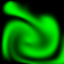

In [14]:
scene.buffers["color"].load(scene.queue)
scene.buffers["velocity"].load(scene.queue)
display(Image.fromarray(scene.render()))
buffer = np.concatenate((scene.buffers["color"].host[:,:,1:2], scene.buffers["velocity"].host), axis=2)

In [18]:
seqt = np.transpose(seq, axes=(0,3,1,2))
print(seqt.shape)

(240, 3, 64, 64)


In [61]:
x = Tensor(seqt).cuda()
x_var = Variable(x.cuda())
y = model(x_var)

In [62]:
print(y.shape)

torch.Size([240, 3, 64, 64])


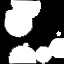

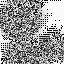

In [64]:
npy = y.data.cpu().numpy()
display(Image.fromarray((255*seqt[0][0]).astype(np.uint8)))
display(Image.fromarray((255*npy[0][0]).astype(np.uint8)))

In [66]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [51]:
buffer_norm = np.abs(buffer)
bmax = np.max(buffer, axis=(0, 1))
bmax

array([1.       , 6.0533934, 7.3110647], dtype=float32)

In [52]:
buffer_norm = buffer_norm/bmax

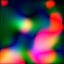

In [53]:
display(Image.fromarray((255*buffer_norm).astype(np.uint8)))

In [30]:
for i in range(1*24):
    scene.step()

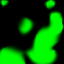

In [31]:
Image.fromarray(scene.render())

In [67]:
batch_size = 64

data = []
for j in range(batch_size):
    scene = Scene(
        ctx,
        (64, 64),
        params={
            "time_step": 1/24,
            "grid_size": 0.001,
            "pressure_steps": 16,
            "viscosity": 1e-4,
    })
    random_draw(scene, 10)
    seq = []
    for i in range(10*24):
        scene.step()
        scene.buffers["color"].load(scene.queue)
        scene.buffers["velocity"].load(scene.queue)
        buffer = np.concatenate((scene.buffers["color"].host[:,:,1:2], scene.buffers["velocity"].host), axis=2)
        seq.append(buffer)
    seq = np.stack(seq)
    data.append(seq)
data = np.stack(data)
print(data.shape)

(64, 240, 64, 64, 3)


In [69]:
datat = np.transpose(data, axes=(1, 0, 4, 2, 3))
print(datat.shape)

(240, 64, 3, 64, 64)


In [70]:
xdata, ydata = datat[:-24], datat[24:]

In [73]:
model.train()

for t, (x, y) in enumerate(zip(xdata, ydata)):
    x_var = Variable(Tensor(x).cuda())
    y_var = Variable(Tensor(y).cuda())

    y_var_pred = model(x_var)
    
    loss = loss_fn(y_var_pred, y_var)
    
    print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

t = 1, loss = 5.5703
t = 2, loss = 3.5954
t = 3, loss = 2.5752
t = 4, loss = 2.1720
t = 5, loss = 1.8964
t = 6, loss = 1.6278
t = 7, loss = 1.3699
t = 8, loss = 1.2533
t = 9, loss = 1.1529
t = 10, loss = 0.9960
t = 11, loss = 0.9388
t = 12, loss = 0.8695
t = 13, loss = 0.7616
t = 14, loss = 0.7110
t = 15, loss = 0.6811
t = 16, loss = 0.6475
t = 17, loss = 0.6033
t = 18, loss = 0.5522
t = 19, loss = 0.5220
t = 20, loss = 0.4867
t = 21, loss = 0.4447
t = 22, loss = 0.4166
t = 23, loss = 0.3904
t = 24, loss = 0.3631
t = 25, loss = 0.3462
t = 26, loss = 0.3294
t = 27, loss = 0.3042
t = 28, loss = 0.2827
t = 29, loss = 0.2700
t = 30, loss = 0.2574
t = 31, loss = 0.2430
t = 32, loss = 0.2316
t = 33, loss = 0.2218
t = 34, loss = 0.2116
t = 35, loss = 0.2011
t = 36, loss = 0.1901
t = 37, loss = 0.1811
t = 38, loss = 0.1735
t = 39, loss = 0.1644
t = 40, loss = 0.1553
t = 41, loss = 0.1489
t = 42, loss = 0.1429
t = 43, loss = 0.1362
t = 44, loss = 0.1311
t = 45, loss = 0.1268
t = 46, loss = 0.12

In [74]:
x = Tensor(datat[0][0:1]).cuda()
x_var = Variable(x.cuda())
y = model(x_var)

In [77]:
y_cpu = np.transpose(y.data.cpu().numpy()[0], axes=(1, 2, 0))
print(y_cpu.shape)

(64, 64, 3)


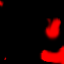

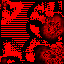

In [82]:
display(Image.fromarray(([255,0,0]*data[0][24]).astype(np.uint8)))
display(Image.fromarray(([255,0,0]*y_cpu).astype(np.uint8)))